In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [2]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [3]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [4]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [5]:
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_hippocraticum = sddk.read_file("c_hippocraticum_enriched.json", "df", publicfolder)

reading file located in a public folder


In [6]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'string', 'wordcount', 'author_id',
       'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual',
       'provenience', 'sentences', 'lemmata', 'lemmata_wordcount',
       'lemmatized_sentences', 'n_sentences', 'lemmata_repl',
       'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*',
       'terms_sum', 'λύπ*_TF', 'ἄλγ*_TF', 'ὀδύν*_TF', 'πόνο*_TF', 'TF_sum',
       'work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'],
      dtype='object')

In [8]:
c_hippocraticum["lemmata_repl"].apply(lambda x: x.count("ἔχις")).sum()

0

In [9]:
def term_in_sentences(sentences):
    flatlist = [word for sen in sentences for word in sen]
    return flatlist.count("ἔχις")
c_hippocraticum["lemmatized_sentences_repl"].apply(term_in_sentences).sum()

0

In [10]:
words = ['λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']

In [11]:
def sentences_with_term(sentences, term, flatlist=False):
    sentences_with_term = [sen for sen in sentences if term in sen]
    if flatlist == True:
        flatlist = [word for sen in sentences_with_term for word in sen]
        return flatlist
    else: 
        return sentences_with_term

In [12]:
for word in words:
    c_hippocraticum[word + "_sents"] = c_hippocraticum["lemmatized_sentences_repl"].apply(lambda x: sentences_with_term(x, word, True))

In [14]:
wordlists = {}
for word in words:
    corpus_wordlist = []
    for wordlist in c_hippocraticum[word + "_sents"]:
        corpus_wordlist.extend(wordlist)
    wordlists[word] = corpus_wordlist

In [15]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " word"] = [tup[0] for tup in word_counts]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* word,ἄλγ* word,ὀδύν* word,πόνο* word
0,λύπ*,ἄλγ*,ὀδύν*,πόνο*
1,γίγνομαι,ἢν,ἢν,ἢν
2,ἢν,πυρετός,ἔχω,γίγνομαι
3,ἄνθρωπος,κεφαλή,γίγνομαι,σῶμα
4,σῶμα,γίγνομαι,πυρετός,πολύς
5,πολύς,ἔχω,κεφαλή,ἔχω
6,κοιλία,ὀδύν*,γαστήρ,κοιλία
7,ἡμέρα,κοιλία,πολύς,μαλλός
8,εἶμι,γαστήρ,ἴσχω,πυρετός
9,ἔχω,ὀσφύς,ὁκόταν,πλείων


In [16]:
wordlists_freqs = {}
for word in words:
    word_freqs = nltk.FreqDist(wordlists[word]).most_common(21)
    wordlists_freqs[word + " (n={0})".format(word_freqs[0][1]) ] = word_freqs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* (n=58),ἄλγ* (n=315),ὀδύν* (n=642),πόνο* (n=651)
0,"(γίγνομαι, 14)","(ἢν, 78)","(ἢν, 198)","(ἢν, 124)"
1,"(ἢν, 14)","(πυρετός, 61)","(ἔχω, 168)","(γίγνομαι, 111)"
2,"(ἄνθρωπος, 12)","(κεφαλή, 61)","(γίγνομαι, 153)","(σῶμα, 102)"
3,"(σῶμα, 12)","(γίγνομαι, 51)","(πυρετός, 109)","(πολύς, 65)"
4,"(πολύς, 7)","(ἔχω, 47)","(κεφαλή, 89)","(ἔχω, 62)"
5,"(κοιλία, 7)","(ὀδύν*, 46)","(γαστήρ, 80)","(κοιλία, 59)"
6,"(ἡμέρα, 6)","(κοιλία, 42)","(πολύς, 66)","(μαλλός, 58)"
7,"(εἶμι, 6)","(γαστήρ, 35)","(ἴσχω, 62)","(πυρετός, 57)"
8,"(ἔχω, 6)","(ὀσφύς, 28)","(ὁκόταν, 59)","(πλείων, 56)"
9,"(ὀλίγος, 6)","(σῶμα, 26)","(κοιλία, 50)","(πᾶς, 55)"


In [17]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " (n={0})".format(word_counts[0][1]) ] = word_freqs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* (n=58),ἄλγ* (n=315),ὀδύν* (n=642),πόνο* (n=651)
0,"(γίγνομαι, 0.01902)","(ἢν, 0.02089)","(ἢν, 0.02468)","(ἢν, 0.01803)"
1,"(ἢν, 0.01902)","(πυρετός, 0.01634)","(ἔχω, 0.02094)","(γίγνομαι, 0.01614)"
2,"(ἄνθρωπος, 0.0163)","(κεφαλή, 0.01634)","(γίγνομαι, 0.01907)","(σῶμα, 0.01483)"
3,"(σῶμα, 0.0163)","(γίγνομαι, 0.01366)","(πυρετός, 0.01359)","(πολύς, 0.00945)"
4,"(πολύς, 0.00951)","(ἔχω, 0.01259)","(κεφαλή, 0.01109)","(ἔχω, 0.00901)"
5,"(κοιλία, 0.00951)","(ὀδύν*, 0.01232)","(γαστήρ, 0.00997)","(κοιλία, 0.00858)"
6,"(ἡμέρα, 0.00815)","(κοιλία, 0.01125)","(πολύς, 0.00823)","(μαλλός, 0.00843)"
7,"(εἶμι, 0.00815)","(γαστήρ, 0.00937)","(ἴσχω, 0.00773)","(πυρετός, 0.00829)"
8,"(ἔχω, 0.00815)","(ὀσφύς, 0.0075)","(ὁκόταν, 0.00735)","(πλείων, 0.00814)"
9,"(ὀλίγος, 0.00815)","(σῶμα, 0.00696)","(κοιλία, 0.00623)","(πᾶς, 0.008)"


In [21]:
set_with_dataframe(PIA_overview.add_worksheet("tfs-in-sentences", 1, 1), wordlists_freqs_df)

In [20]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    tfs = [np.round(tup[1] / word_count, 5) for tup in word_counts]
    tf_words = [tup[0] for tup in word_counts]
    wordlists_freqs[word + " words"] = tf_words[1:]
    wordlists_freqs[word + " TFs"] = tfs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* words,λύπ* TFs,ἄλγ* words,ἄλγ* TFs,ὀδύν* words,ὀδύν* TFs,πόνο* words,πόνο* TFs
0,γίγνομαι,0.01902,ἢν,0.02089,ἢν,0.02468,ἢν,0.01803
1,ἢν,0.01902,πυρετός,0.01634,ἔχω,0.02094,γίγνομαι,0.01614
2,ἄνθρωπος,0.01630,κεφαλή,0.01634,γίγνομαι,0.01907,σῶμα,0.01483
3,σῶμα,0.01630,γίγνομαι,0.01366,πυρετός,0.01359,πολύς,0.00945
4,πολύς,0.00951,ἔχω,0.01259,κεφαλή,0.01109,ἔχω,0.00901
5,κοιλία,0.00951,ὀδύν*,0.01232,γαστήρ,0.00997,κοιλία,0.00858
6,ἡμέρα,0.00815,κοιλία,0.01125,πολύς,0.00823,μαλλός,0.00843
7,εἶμι,0.00815,γαστήρ,0.00937,ἴσχω,0.00773,πυρετός,0.00829
8,ἔχω,0.00815,ὀσφύς,0.00750,ὁκόταν,0.00735,πλείων,0.00814
9,ὀλίγος,0.00815,σῶμα,0.00696,κοιλία,0.00623,πᾶς,0.00800


In [18]:
cats = c_hippocraticum["work_cat_linka"].unique().tolist()
cats

['Theoretical', 'Other', 'Practical']

In [ ]:
most_common = []
for column in wordlists_freqs_df.columns:
    most_common.extend([tup[0] for tup in wordlists_freqs_df[column].tolist()])

<AxesSubplot:xlabel='λύπ* TFs', ylabel='λύπ* words'>

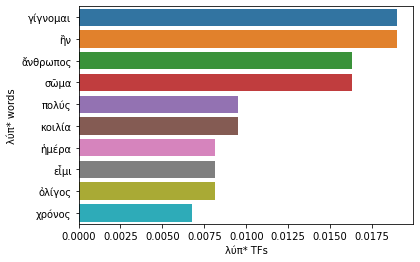

In [76]:
xcol = wordlists_freqs_df["λύπ* TFs"]
ycol = wordlists_freqs_df["λύπ* words"]
sns.barplot(x=xcol, y=ycol)

In [ ]:
for word in words:
    
sns.barplot(x=xcol, y=ycol)

<AxesSubplot:>

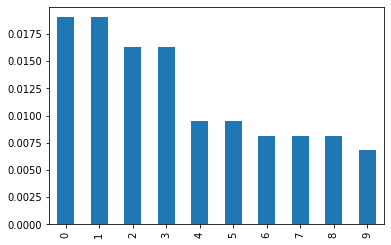

In [74]:
wordlists_freqs_df["λύπ* TFs"].plot.bar()

In [28]:
wordlists = {}
for word in words:
    corpus_wordlist = []
    for wordlist in c_hippocraticum[word + "_sents"]:
        corpus_wordlist.extend(wordlist)
    wordlists[word] = corpus_wordlist

In [26]:
set_with_dataframe(PIA_overview.worksheet("wordlists_freqs_df"), wordlists_freqs_df)

In [28]:
most_common = []
for column in wordlists_freqs_df.columns:
    most_common.extend([tup[0] for tup in wordlists_freqs_df[column].tolist()])

In [31]:
list(set(most_common))

['ὀλίγος',
 'ὀσφύς',
 'δοκέω',
 'ψυχρός',
 'νόσος',
 'χολή',
 'ἄλγ*',
 'αἷμα',
 'χρόνος',
 'κενεών',
 'μαλλός',
 'ἡμέρα',
 'ἰσχυρός',
 'ὁκόταν',
 'συμβαίνω',
 'ἴσχω',
 'ἐσθίω',
 'σιτίον',
 'λαμβάνω',
 'πρότερος',
 'σῶμα',
 'δίδωμι',
 'ἔχις',
 'ἢν',
 'πλείων',
 'παύω',
 'γίγνομαι',
 'ποιέω',
 'ἄνθρωπος',
 'ἰξύς',
 'θερμός',
 'πόνο*',
 'γαστήρ',
 'πυρετός',
 'ὀδύν*',
 'κεφαλή',
 'σάρξ',
 'κοιλία',
 'εἶμι',
 'ὀξύς',
 'πᾶς',
 'πολύς',
 'μήτρα']